# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
df = pd.read_csv('../../data/house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
assert df.shape == (1460, 80)

In [5]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределени или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регресси через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выьросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

6.509812011089439

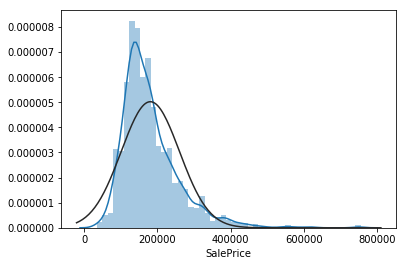

In [6]:
import scipy as scipy
A = sns.distplot(df['SalePrice'].dropna(), fit=scipy.stats.norm)
scipy.stats.kurtosis(df['SalePrice'])

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.164745194154, 180921.19589041095, 0.93196656415129864))

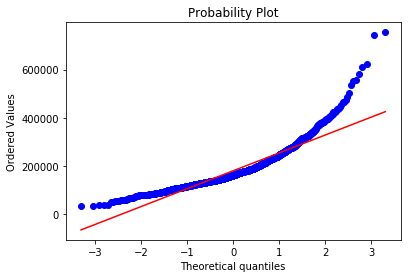

In [7]:
scipy.stats.probplot(df['SalePrice'], plot=plt)

## 1.2 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

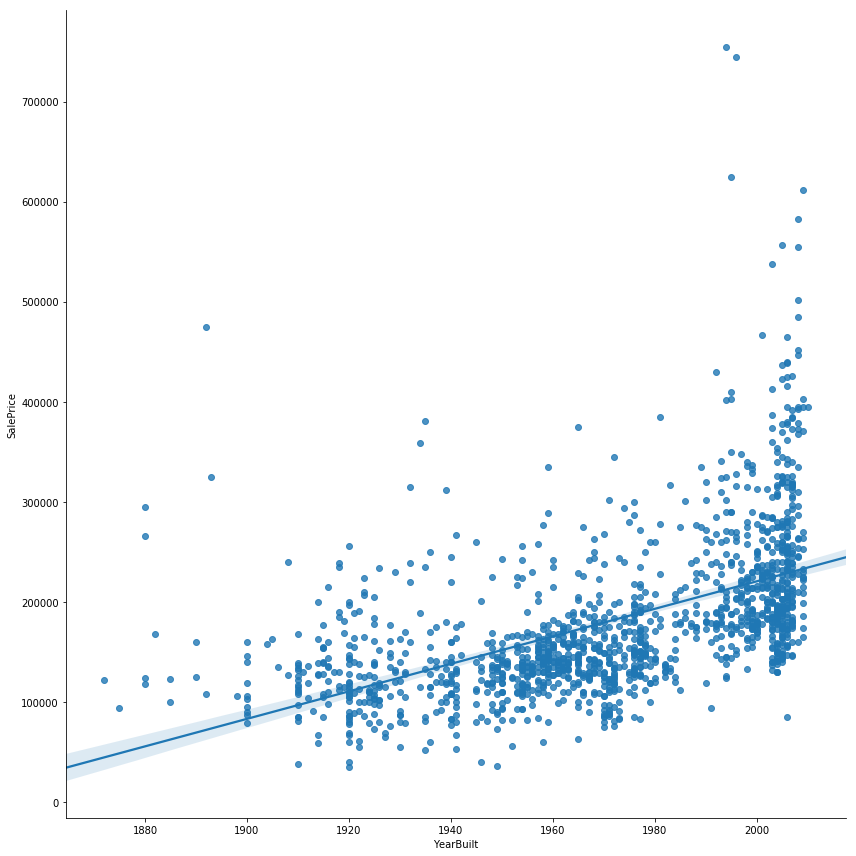

In [8]:
sns.lmplot('YearBuilt', 'SalePrice', data=df, size=12)


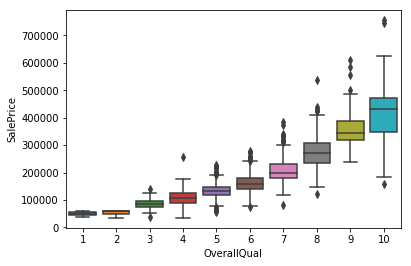

In [9]:
sns.boxplot(df['OverallQual'], df['SalePrice'])

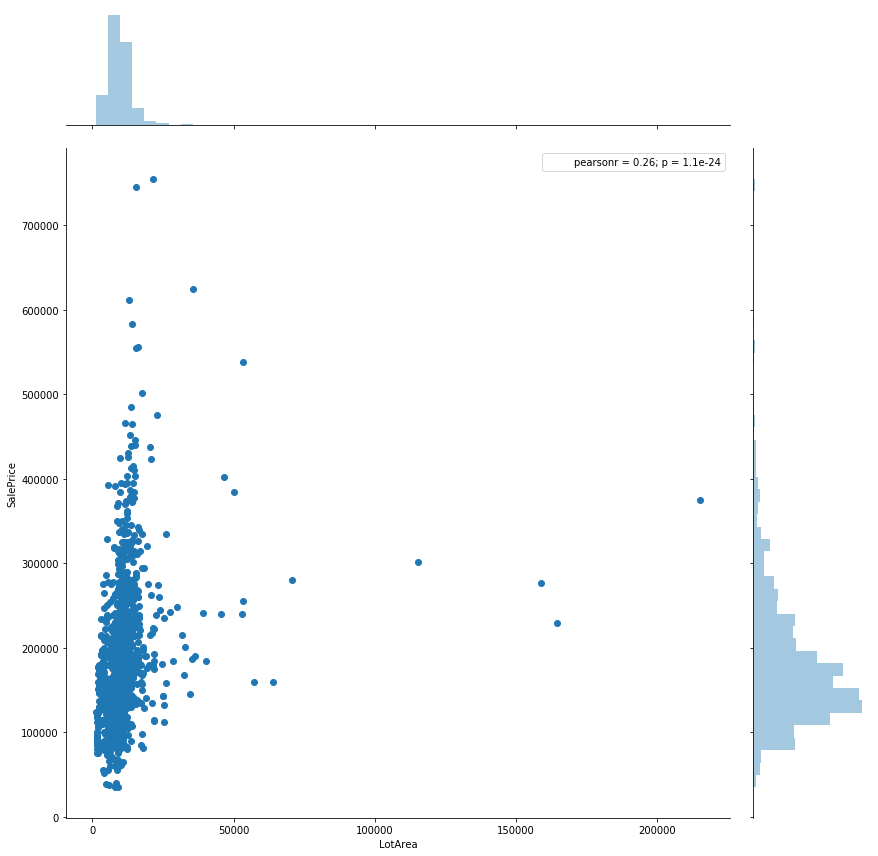

In [10]:
sns.jointplot(df['LotArea'], df['SalePrice'], size=12)

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

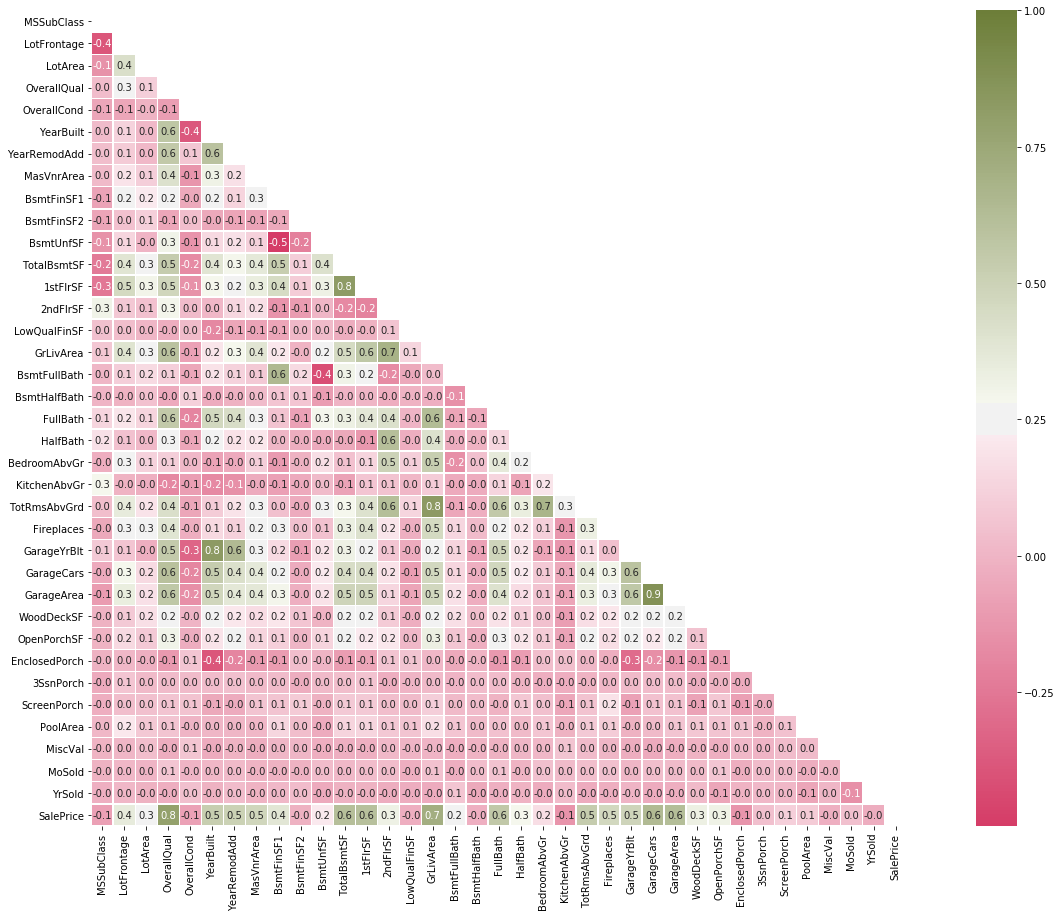

In [11]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25, 15))
cmap = sns.diverging_palette(1, 100, as_cmap=True)
sns.heatmap(df.corr(),cmap=cmap, square=True,linewidths=.5, mask=mask,annot=True, fmt=".1f")

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

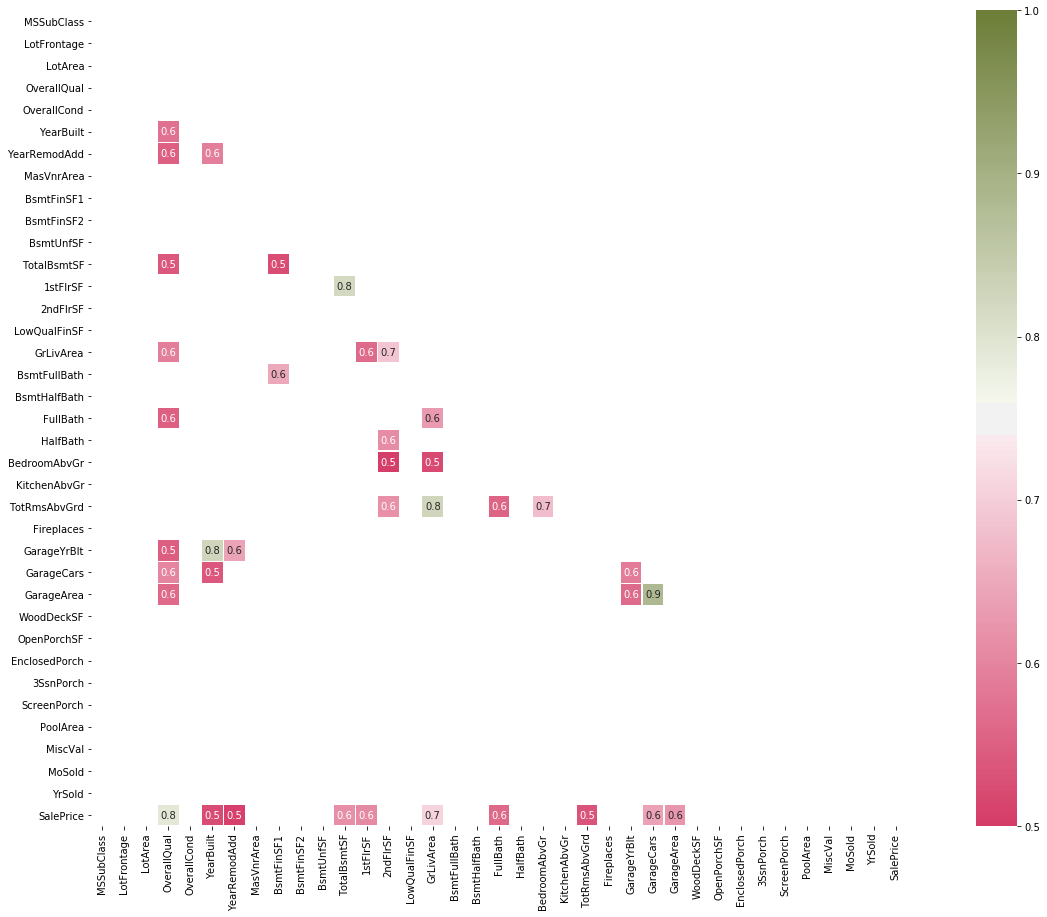

In [12]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[(np.triu_indices_from(mask))] = True
mask[(df.corr() < 0.5)] = True
cmap = sns.diverging_palette(1, 100, as_cmap=True)
f, ax = plt.subplots(figsize=(25, 15))
H = sns.heatmap(df.corr(),cmap=cmap, square=True,linewidths=.5, mask=mask,annot=True, fmt=".1f", vmin=0.5)

## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hinst: https://stackoverflow.com/a/38134049/3205200

In [13]:
df = df.fillna(value=0.0)
for i in range(len(df.columns)):
    if (len(df[df[df.columns[i]] == 0.0]) > 0):
        A = (df[df[df.columns[i]] == 0.0])        
        print("%s - %s" % (df.columns[i],len(A.index)))


LotFrontage - 259
Alley - 1369
MasVnrType - 8
MasVnrArea - 869
BsmtQual - 37
BsmtCond - 37
BsmtExposure - 38
BsmtFinType1 - 37
BsmtFinSF1 - 467
BsmtFinType2 - 38
BsmtFinSF2 - 1293
BsmtUnfSF - 118
TotalBsmtSF - 37
Electrical - 1
2ndFlrSF - 829
LowQualFinSF - 1434
BsmtFullBath - 856
BsmtHalfBath - 1378
FullBath - 9
HalfBath - 913
BedroomAbvGr - 6
KitchenAbvGr - 1
Fireplaces - 690
FireplaceQu - 690
GarageType - 81
GarageYrBlt - 81
GarageFinish - 81
GarageCars - 81
GarageArea - 81
GarageQual - 81
GarageCond - 81
WoodDeckSF - 761
OpenPorchSF - 656
EnclosedPorch - 1252
3SsnPorch - 1436
ScreenPorch - 1344
PoolArea - 1453
PoolQC - 1453
Fence - 1179
MiscFeature - 1406
MiscVal - 1408


In [14]:
df = df.fillna(value=0.0)
for i in range(len(df.columns)):
    if (len(df[df[df.columns[i]] == 0.0]) > 0):
        A = (df[df[df.columns[i]] == 0.0])
        B = df[[df.columns[i]]]
        print("%s - %s" % (df.columns[i],(len(A.index)/len(B.index))))

LotFrontage - 0.1773972602739726
Alley - 0.9376712328767123
MasVnrType - 0.005479452054794521
MasVnrArea - 0.5952054794520548
BsmtQual - 0.025342465753424658
BsmtCond - 0.025342465753424658
BsmtExposure - 0.026027397260273973
BsmtFinType1 - 0.025342465753424658
BsmtFinSF1 - 0.3198630136986301
BsmtFinType2 - 0.026027397260273973
BsmtFinSF2 - 0.8856164383561644
BsmtUnfSF - 0.08082191780821918
TotalBsmtSF - 0.025342465753424658
Electrical - 0.0006849315068493151
2ndFlrSF - 0.5678082191780822
LowQualFinSF - 0.9821917808219178
BsmtFullBath - 0.5863013698630137
BsmtHalfBath - 0.9438356164383561
FullBath - 0.0061643835616438354
HalfBath - 0.6253424657534247
BedroomAbvGr - 0.00410958904109589
KitchenAbvGr - 0.0006849315068493151
Fireplaces - 0.4726027397260274
FireplaceQu - 0.4726027397260274
GarageType - 0.05547945205479452
GarageYrBlt - 0.05547945205479452
GarageFinish - 0.05547945205479452
GarageCars - 0.05547945205479452
GarageArea - 0.05547945205479452
GarageQual - 0.05547945205479452
Gar

In [ ]:
df1 = df.fillna(value=0.0)
L = range(len(df1.columns))
for i in L:
    if (len(df1[df1[df1.columns[i]] == 0.0]) > 0):
        A = (df1[df1[df1.columns[i]] == 0.0])
        B = df1[[df1.columns[i]]]
        if ((len(A.index)/len(B.index)) > 0.1):
            del df1[df1.columns[i]]

In [97]:
L = range(len(df1.columns))
for i in L:
    if (len(df1[df1[df1.columns[i]] == 0.0]) > 0):
        A = (df1[df1[df1.columns[i]] == 0.0])
        B = df1[[df1.columns[i]]]
        if ((len(A.index)/len(B.index)) > 0.1):
            del df1[df1.columns[i]]

In [ ]:
df1 = df1.fillna(value=0.0)
for i in range(len(df1.columns[1])):
        if (df1[df1.columns[1]].dtype == object):
            if((df1[df1.columns[1]][i]) is 0.0):
                (df1[df1.columns[1]][i]) = 'unknown'


In [235]:
df1 = df1.fillna(value=0.0)
for i in range(len(df1.columns[1])):
        if (df1[df1.columns[1]].dtype != object):
            if((df1[df1.columns[1]][i]) is 0.0):
                (df1[df1.columns[1]][i]) = df1[df1.columns[1]].mean()

True

In [ ]:
## 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [236]:
A = pd.get_dummies(df1)
X = A.drop(['SalePrice'], axis=1)
y = A['SalePrice']

## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [238]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)
for coef, col in sorted(zip(lr.coef_, A.columns), key=lambda x: np.abs(x[0])):
    print("{} \t {}".format(np.round(coef, 2), col))

0.8 	 LotArea
-12.45 	 MSSubClass
18.15 	 GarageArea
-19.79 	 BsmtUnfSF
-23.56 	 1stFlrSF
-38.53 	 GarageYrBlt
41.01 	 TotalBsmtSF
75.02 	 GrLivArea
91.47 	 YearRemodAdd
123.57 	 Heating_GasA
157.29 	 Electrical_FuseF
-214.5 	 Neighborhood_SawyerW
-223.23 	 KitchenQual_TA
-230.19 	 Exterior2nd_AsphShn
315.3 	 YearBuilt
-345.01 	 BsmtFinType2_ALQ
361.98 	 MSZoning_RL
-392.29 	 BsmtFinType1_ALQ
-403.04 	 MoSold
-406.44 	 YrSold
-517.33 	 Exterior1st_AsphShn
-540.32 	 Exterior1st_VinylSd
-547.5 	 Exterior2nd_Wd Sdng
569.29 	 Heating_Wall
587.47 	 Condition1_Artery
610.57 	 TotRmsAbvGrd
675.2 	 BsmtFinType1_Rec
-700.14 	 BsmtFinType2_GLQ
-741.56 	 LotShape_IR3
-846.21 	 LandSlope_Sev
862.52 	 MasVnrType_BrkFace
-893.64 	 LotShape_Reg
-902.49 	 Exterior1st_Plywood
-952.25 	 Exterior1st_CemntBd
-971.23 	 Neighborhood_IDOTRR
-987.0 	 HeatingQC_TA
987.0 	 CentralAir_N
-1036.29 	 SaleType_New
1069.77 	 Neighborhood_BrDale
1086.27 	 GarageType_Basment
-1135.8 	 Condition1_Norm
1151.6 	 Exterior2

In [243]:
from sklearn import model_selection
model_selection.cross_val_score(lr,X =X, y=y, cv=5).mean()

0.79262091447470007

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [250]:
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 5)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in alphas:
    lasso = Lasso(alpha = alpha, random_state=42)
    lasso.fit(X, y)
    coefs_lasso[i, :] = lasso.coef_
    
    ridge = Ridge(alpha = alpha, random_state=42)
    ridge.fit(X, y)
    coefs_ridge[i, :] = ridge.coef_
    
    i += 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


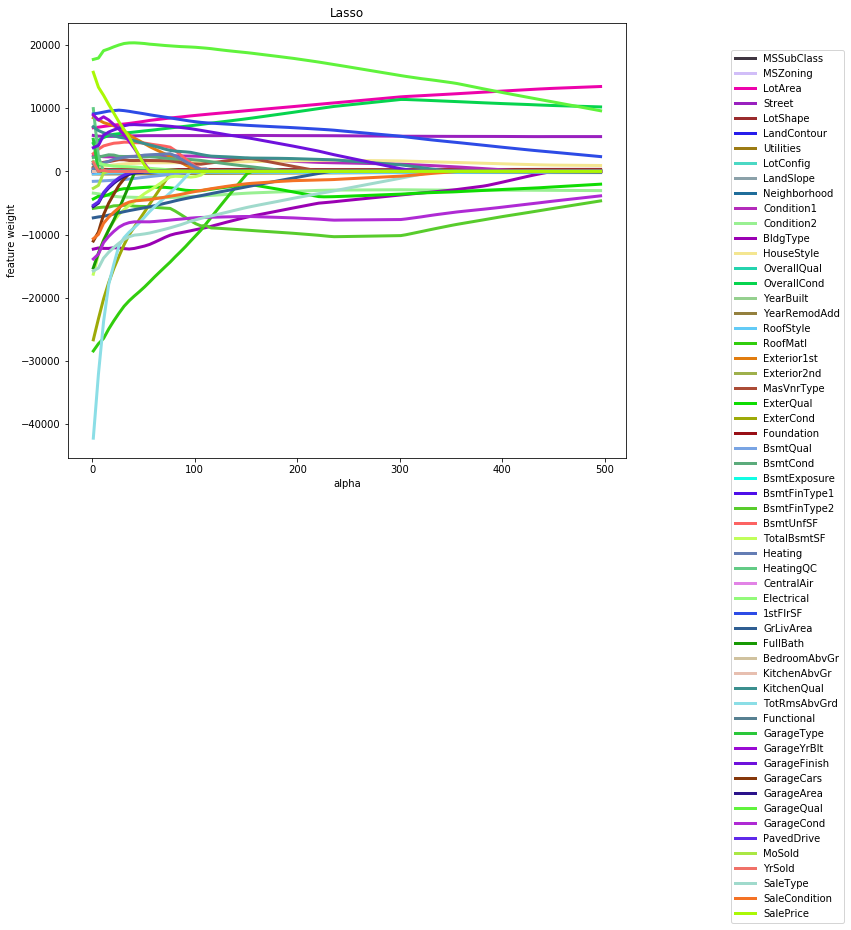

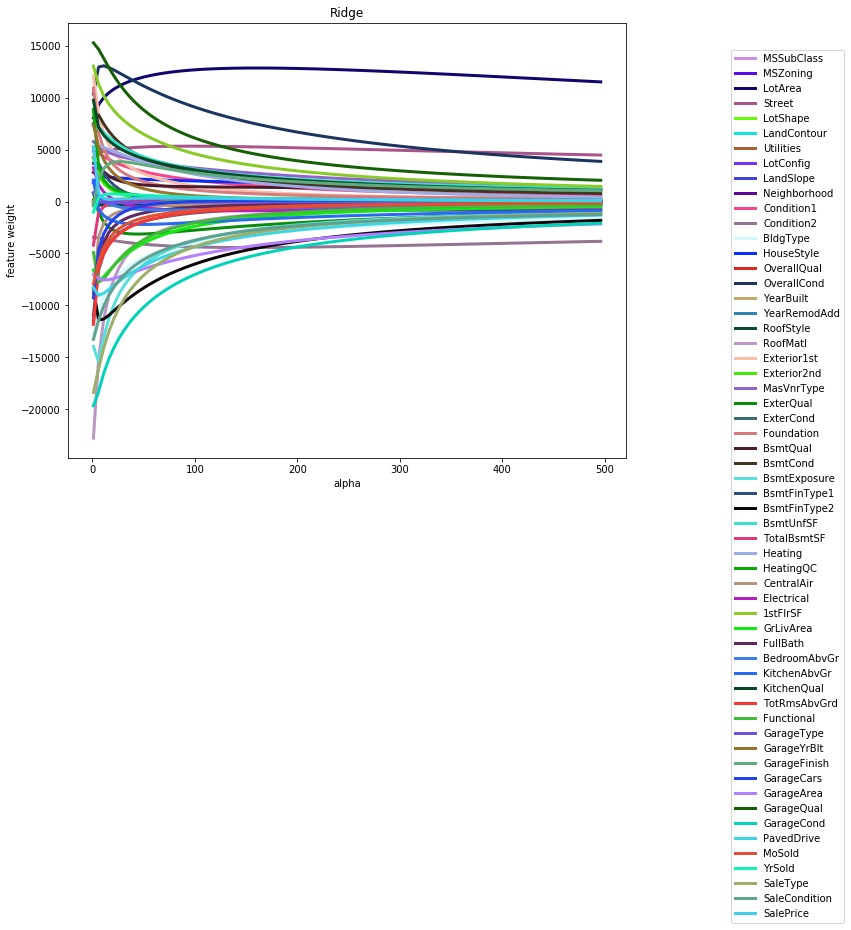

In [251]:
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, df1.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, df1.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha = 176


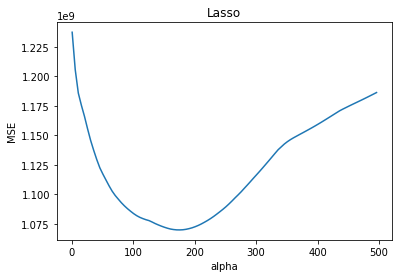

In [255]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, random_state=42,cv=5)
lasso_cv.fit(X, y)
mean_mse = np.mean(lasso_cv.mse_path_, axis = 1)
plt.plot(lasso_cv.alphas_, mean_mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso')
print('alpha = {}'.format(lasso_cv.alpha_))


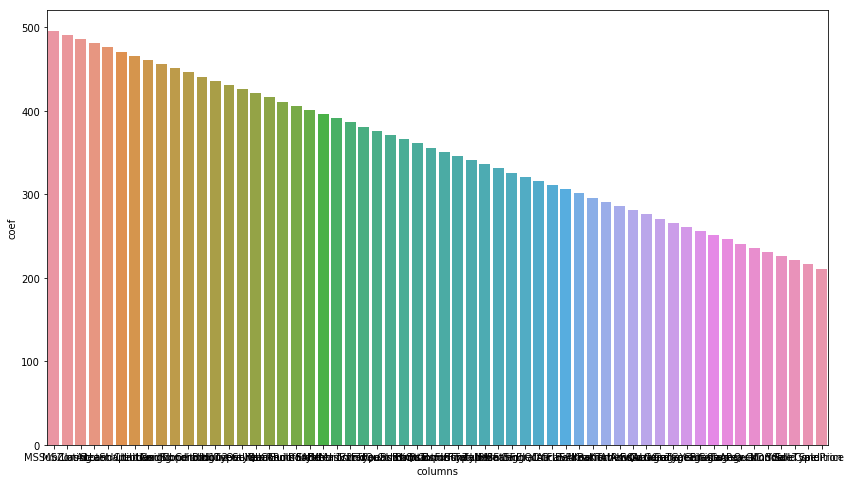

In [256]:
plt.figure(figsize=(14,8))
sns.barplot(x='columns', y='coef',data=pd.DataFrame(list(zip(lasso_cv.alphas_, df1.columns)), columns=["coef", "columns"]))

In [258]:
error = abs(np.mean(model_selection.cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=5, scoring='neg_mean_absolute_error')))
np.round(error,3)

16816.143

## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

In [261]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)


(978, 264) (482, 264)


Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

In [270]:
ls = Lasso()
ls.fit(X_train, y_train)
A = ls.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([ 186141.83087687,  121416.53220269,  122874.2186639 ,
        111165.30991869,  233370.4046646 ,  109673.78137975,
        148869.77868462,  155847.19014119,  229272.48598681,
        234751.99698039,  144595.00454086,  196129.97991599,
        131913.07851563,  210285.55314751,  132057.24697598,
        117740.4964208 ,  133194.75087069,  136381.56633548,
        348011.08787997,   67765.46841799,   78574.58081332,
        180699.10526397,   90282.59902012,  165615.15046311,
        107017.1505362 ,  147280.03173863,  534476.04324   ,
        144946.04598759,   67754.39836221,  161667.56444509,
        106823.12525865,  377805.96546139,  107850.87284609,
         86703.42650922,  125485.85870602,  156244.45381016,
        197002.49925889,  203304.20736573,  164304.32889024,
        133984.01095942,   74941.52576636,  206083.35283342,
        184439.55918564,  146933.73179433,  272587.87120407,
        252207.87468217,  162805.26250315,  158521.59933226,
        180343.4447725 ,

Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.